## Section 5. Test Result

Load TensorFlow and check GPU availability as pre-flight check.

In [10]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

Get the version of TensorFlow, related version information, and available GPU.

In [2]:
print("Tensorflow Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("Numbers of GPU Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print("Name:", gpu.name, "; Type:", gpu.device_type)
    tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Version:  2.19.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Numbers of GPU Available:  1
Num GPUs Available:  1
Name: /physical_device:GPU:0 ; Type: GPU


Since the on-prem environment only has 8GB of VRAM,set `mixed_precision` to enable mixed precision training, saving about 40% of VRAM and usually accelerating 4070 training by 40%.

### Step A. Defining Functions

Environment Variables:

In [3]:
TEST_CSV_PATH = 'dataset/test_set.csv'
INFERENCE_BATCH_SIZE = 16
MODEL_DIR = "models"
SEED = 439

This function is responsible for generating test datasets based on specified preprocessing methods.Enforce `shuffle=False` to ensure predictions align with ground truth labels.

In [4]:
def get_inference_dataset(df, method):
    
    print(f"Creating Test Dataset with method: '{method}'")
    
    ds = create_dataset(
        df, 
        method=method, 
        batch_size=INFERENCE_BATCH_SIZE, 
        shuffle=False # Critical: Do not shuffle for inference or the Confusion Matrix will be incorrect.
    )
    
    return ds

This function is responsible for executing predictions, drawing confusion matrices, and printing reports.

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_and_plot_cm(model, ds, title_prefix):
    
    # 1. Generate class name according to CLASS_MAP
    sorted_map = sorted(CLASS_MAP.items(), key=lambda item: item[1])
    class_names = [k for k, v in sorted_map]
    
    # 2. Run prediction
    print(f"Running prediction for {title_prefix}...")
    y_pred_probs = model.predict(ds, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 3. Get the real label
    y_true = []
    for images, labels in ds:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    
    # 4. Calculate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    acc = np.mean(y_true == y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Test Set Confusion Matrix\nModel: {title_prefix}\nAccuracy: {acc:.4f}')
    plt.show()
    
    # 5. Generate classification report
    print(f"Classification Report ({title_prefix}):\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    return acc

### B, Load Test Data

In [6]:
import pandas as pd

if not os.path.exists(TEST_CSV_PATH):
    raise FileNotFoundError(f"Test CSV not found at {TEST_CSV_PATH}")

df_test = pd.read_csv(TEST_CSV_PATH)
print(f"Loaded Test Set: {len(df_test)} samples")

# Examine the distribution of the test set
print("Test Set Distribution:")
print(df_test['class_name'].value_counts())

Loaded Test Set: 13969 samples
Test Set Distribution:
class_name
non-demented          10919
dementia_mild          1952
dementia_very_mild      854
dementia_moderate       244
Name: count, dtype: int64


## Evaluation

In [7]:
from data_loader import create_dataset, CLASS_MAP

### Evaluation 1 - RQ1 Baseline (Duplicate)

Session cleared. Starting RQ1 Baseline evaluation...
Creating Test Dataset with method: 'duplicate'
Running prediction for RQ1 Baseline...
874/874 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step


2025-12-19 02:25:08.932854: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


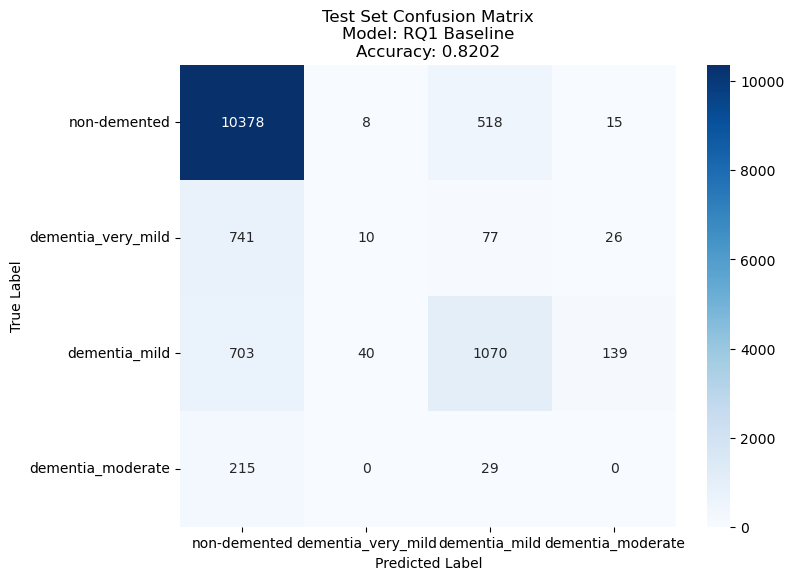

Classification Report (RQ1 Baseline):

                    precision    recall  f1-score   support

      non-demented       0.86      0.95      0.90     10919
dementia_very_mild       0.17      0.01      0.02       854
     dementia_mild       0.63      0.55      0.59      1952
 dementia_moderate       0.00      0.00      0.00       244

          accuracy                           0.82     13969
         macro avg       0.42      0.38      0.38     13969
      weighted avg       0.77      0.82      0.79     13969



In [ ]:
METHOD = 'duplicate'
MODEL_NAME = "RQ1 Baseline"
MODEL_PATH = os.path.join(MODEL_DIR, f"resnet101_duplicate_best.keras")

# 1. Clear Session to release VRAM
tf.keras.backend.clear_session()
print(f"Session cleared. Starting {MODEL_NAME} evaluation...")

# 2. Prepare test dataset and model
test_ds = get_inference_dataset(df_test, method=METHOD)
model = tf.keras.models.load_model(MODEL_PATH)

# 3. Execute evaluation
acc_baseline = evaluate_and_plot_cm(model, test_ds, title_prefix=MODEL_NAME)

# 4. Delete model object (release RAM)
del model

### Evaluation 2 - RQ2 Jet Colormap

Session cleared. Starting RQ2 Jet evaluation...
Creating Test Dataset with method: 'jet'
Running prediction for RQ2 Jet...
874/874 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step


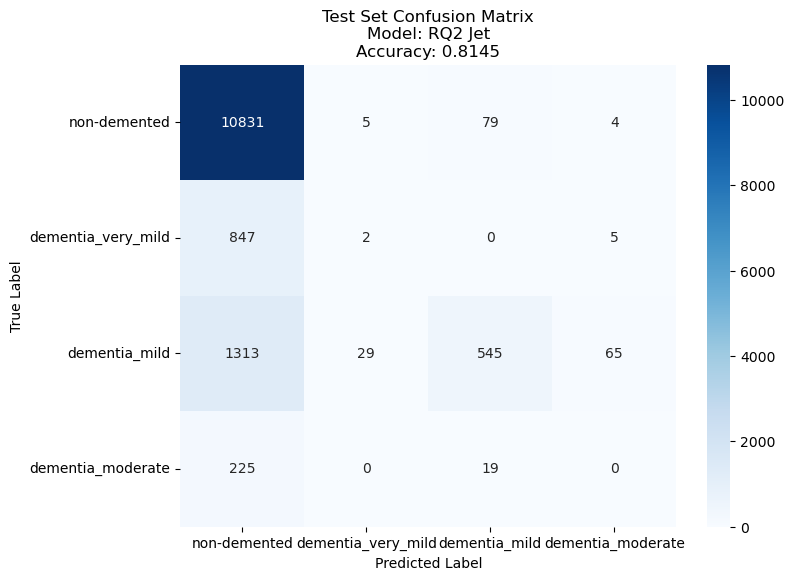

Classification Report (RQ2 Jet):

                    precision    recall  f1-score   support

      non-demented       0.82      0.99      0.90     10919
dementia_very_mild       0.06      0.00      0.00       854
     dementia_mild       0.85      0.28      0.42      1952
 dementia_moderate       0.00      0.00      0.00       244

          accuracy                           0.81     13969
         macro avg       0.43      0.32      0.33     13969
      weighted avg       0.76      0.81      0.76     13969



In [11]:
METHOD = 'jet'
MODEL_NAME = "RQ2 Jet"
MODEL_PATH = os.path.join(MODEL_DIR, "resnet101_pure_jet_best.keras")

# 1. Clear Session to release VRAM
tf.keras.backend.clear_session()
print(f"Session cleared. Starting {MODEL_NAME} evaluation...")

# 2. Prepare test dataset and model
test_ds = get_inference_dataset(df_test, method=METHOD)
model = tf.keras.models.load_model(MODEL_PATH)

# 3. Execute evaluation
acc_baseline = evaluate_and_plot_cm(model, test_ds, title_prefix=MODEL_NAME)

# 4. Delete model object (release RAM)
del model

### Evaluation 3 - RQ2 Viridis Colormap

Session cleared. Starting RQ2 Viridis evaluation...
Creating Test Dataset with method: 'viridis'


/home/csning1998/miniconda3/envs/ml-for-biomedicine/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 842 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running prediction for RQ2 Viridis...
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 55ms/step


2025-12-19 02:37:29.208871: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


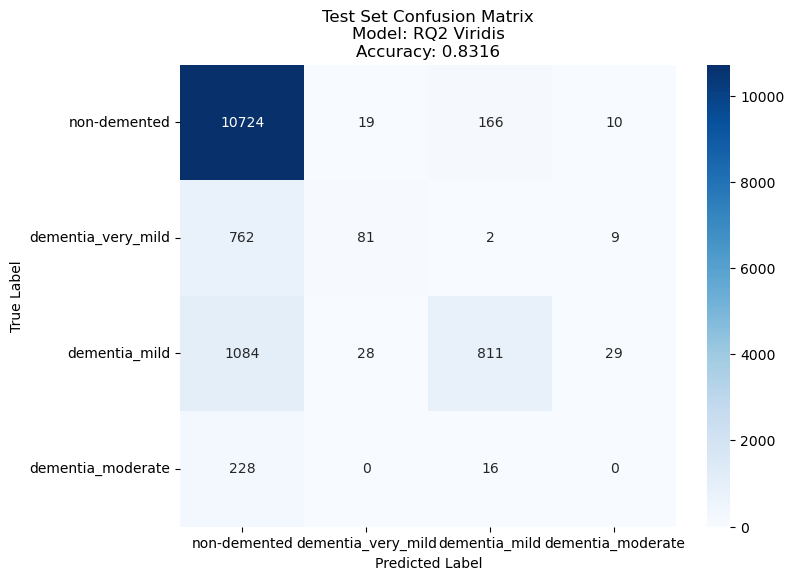

Classification Report (RQ2 Viridis):

                    precision    recall  f1-score   support

      non-demented       0.84      0.98      0.90     10919
dementia_very_mild       0.63      0.09      0.16       854
     dementia_mild       0.82      0.42      0.55      1952
 dementia_moderate       0.00      0.00      0.00       244

          accuracy                           0.83     13969
         macro avg       0.57      0.37      0.40     13969
      weighted avg       0.81      0.83      0.79     13969



In [9]:
METHOD = 'viridis'
MODEL_NAME = "RQ2 Viridis"
MODEL_PATH = os.path.join(MODEL_DIR, f"resnet101_viridis_best.keras")

# 1.
tf.keras.backend.clear_session()
print(f"Session cleared. Starting {MODEL_NAME} evaluation...")

# 2.
test_ds = get_inference_dataset(df_test, method=METHOD)
model = tf.keras.models.load_model(MODEL_PATH)

# 3.
acc_viridis = evaluate_and_plot_cm(model, test_ds, title_prefix=MODEL_NAME)

# 4.
del model

### Evaluation 4 - RQ2 CLAHE + Jet

Session cleared. Starting RQ2 CLAHE+Jet evaluation...
Creating Test Dataset with method: 'clahe_jet'
Running prediction for RQ2 CLAHE+Jet...
874/874 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step


2025-12-19 02:39:17.831198: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


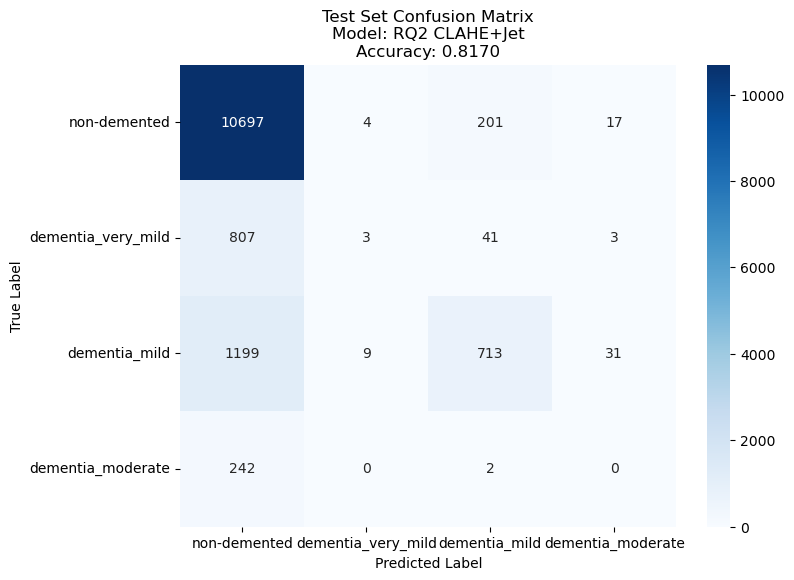

Classification Report (RQ2 CLAHE+Jet):

                    precision    recall  f1-score   support

      non-demented       0.83      0.98      0.90     10919
dementia_very_mild       0.19      0.00      0.01       854
     dementia_mild       0.75      0.37      0.49      1952
 dementia_moderate       0.00      0.00      0.00       244

          accuracy                           0.82     13969
         macro avg       0.44      0.34      0.35     13969
      weighted avg       0.76      0.82      0.77     13969



In [9]:
METHOD = 'clahe_jet'
MODEL_NAME = "RQ2 CLAHE+Jet"
MODEL_PATH = os.path.join(MODEL_DIR, f"resnet101_{METHOD}_best.keras")

# 1.
tf.keras.backend.clear_session()
print(f"Session cleared. Starting {MODEL_NAME} evaluation...")

# 2.
test_ds = get_inference_dataset(df_test, method=METHOD)
model = tf.keras.models.load_model(MODEL_PATH)

# 3.
acc_viridis = evaluate_and_plot_cm(model, test_ds, title_prefix=MODEL_NAME)

# 4.
del model